In [2]:
# -------- IMPORTS --------
from simulation.experiment import ForwardExperiment1D
from utility.distributions import spike, ricker, gaussian, raised_cosine, sinc, homogeneous, exponential, polynomial
from utility.plotting import plot_uv, plot_state, plot_medium, plot_heatmap, plot_multi_v1

In [2]:
# Set IBM Account
# from qiskit_ibm_runtime import QiskitRuntimeService
# QiskitRuntimeService.delete_account()
# QiskitRuntimeService.save_account(
#     channel='ibm_quantum',
#     instance='ibm-q/open/main',
#     token='',
#     overwrite=True
#     )
# service = QiskitRuntimeService()
# service.backends()


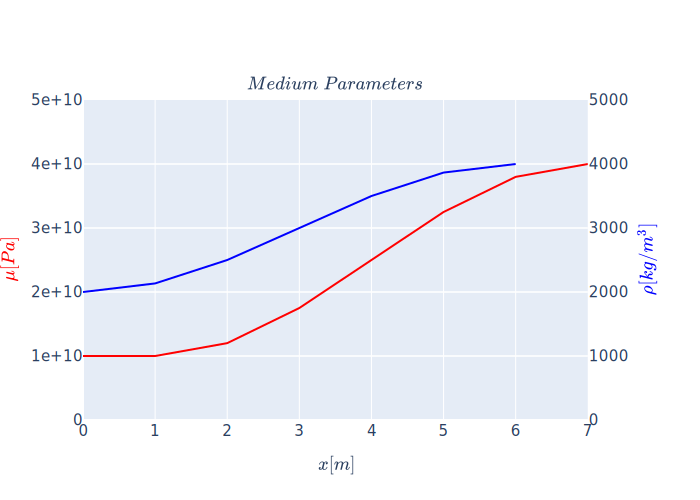

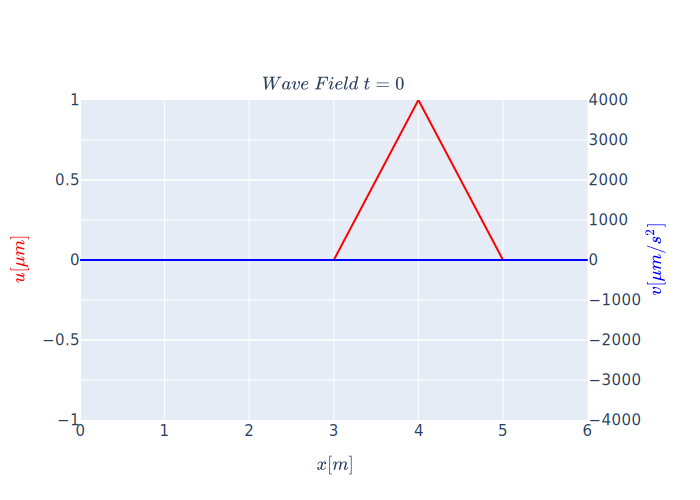

In [3]:
# Define parameters
nx = 7
parameters = {
    'dx': 1,
    'nx': nx, 
    'dt': 0.0002,
    'nt': 19,
    'order': 1,
    'bcs': {'left': 'DBC', 'right': 'DBC'},
    'mu': raised_cosine(3e10, nx+1, nx, 6, 1e10),
    'rho': raised_cosine(2e3, nx, nx-1, 6, 2e3),
    'u': spike(1, nx, nx//2+1),
    'v': homogeneous(0, nx),
    'backend': {
        'shots': 1000,
        'optimization': 3,
        'resilience': 1
        }
    }

# Plot medium and initial state
plot_medium(parameters['mu'], parameters['rho']).show(renderer='svg')
plot_uv(parameters['u'], parameters['v'],0, plot_v=True).show(renderer='svg')


In [3]:
# # Run experiment
# experiment = ForwardExperiment1D(verbose=2)
# experiment.add_solver('ode', **parameters)
# # experiment.add_solver('exp', **parameters)
# experiment.add_solver('local', **parameters)
# experiment.add_solver('cloud', **parameters)
# results = experiment.run()

# Read experiment
id = '20231202T124619'
experiment = ForwardExperiment1D(experiment_id=id, verbose=2)
results = experiment.load()


2023-12-02 17:22:28,284 - INFO - Loading experiment with time stamp: 20231202T124619.

2023-12-02 17:22:28,287 - INFO - Loading data for solver 1.
2023-12-02 17:22:28,311 - INFO - Loading data for solver 2.
2023-12-02 17:22:28,323 - INFO - Loading data for solver 3.
2023-12-02 17:22:28,323 - WARNING - No data for solver 3 found. Loading from cloud.
2023-12-02 17:22:28,324 - INFO - Parameters checked for validity.
2023-12-02 17:22:28,324 - INFO - Solving for 19 time steps.
2023-12-02 17:22:28,325 - INFO - Calculating Transformation and Hamiltonian.
2023-12-02 17:22:28,325 - INFO - Calculation completed.
2023-12-02 17:22:28,336 - INFO - Medium initialized.
2023-12-02 17:22:28,369 - INFO - Initial state transformed.
2023-12-02 17:22:28,385 - INFO - Loading jobs from IBM Quantum.
2023-12-02 17:23:05,027 - INFO - Jobs completed: 3 | 3
2023-12-02 17:23:06,849 - INFO - Jobs completed.
2023-12-02 17:23:06,850 - INFO - Running tomography.
2023-12-02 17:23:06,857 - INFO - Tomography step: 1 | 18

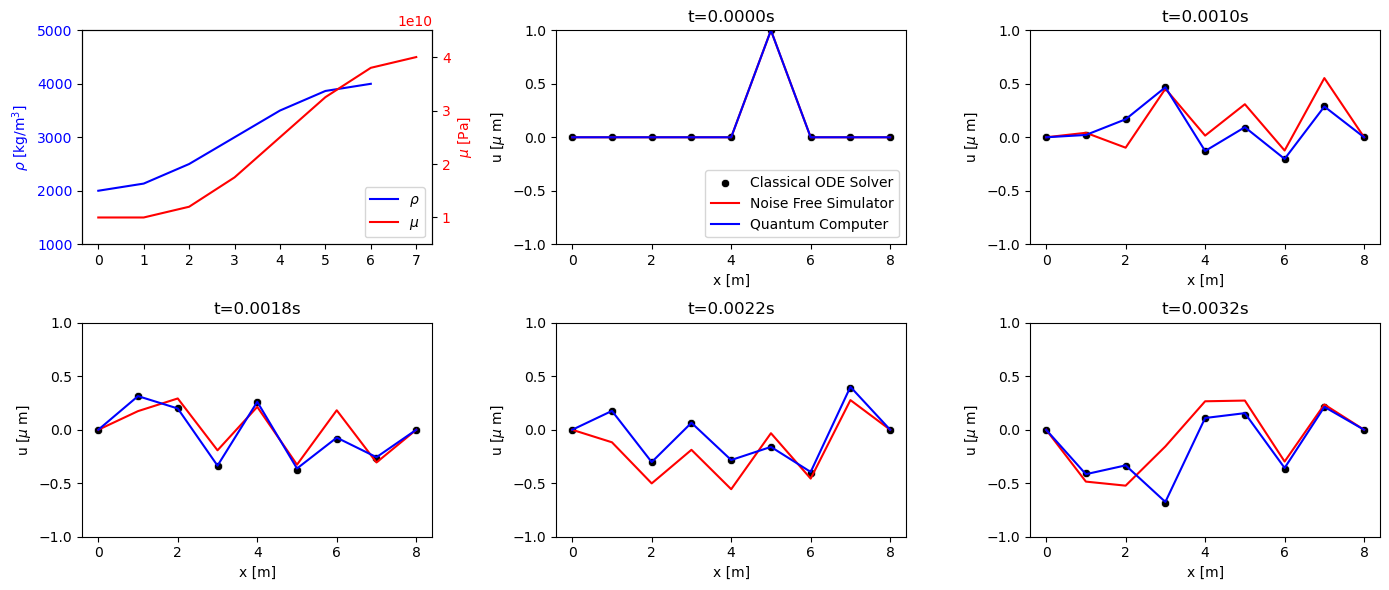

In [24]:
u_ode = results[0]['field']['u']
u_sim = results[2]['field']['u']
u_qpu = results[1]['field']['u']
rho = results[0]['medium']['rho'][0]
mu = results[0]['medium']['mu'][0]
times = results[0]['times']
bcs = {'left': 'DBC', 'right': 'DBC'}
idx = [0, 5, 9, 11, 16] # 3, 4, 6, 8, 9, 15, 16, 18 || 5, 9, 11, 16
fig = plot_multi_v1(idx, times, u_ode, u_sim, u_qpu, rho, mu, bcs)
fig.savefig('figures/fig2.png', format='png', bbox_inches='tight', dpi=300)


In [5]:
# Testing - Accuracy
import numpy as np
import plotly.express as px
l2_errors = np.linalg.norm(results[1]['field']['u'] - results[0]['field']['u'], axis=1) / np.linalg.norm(results[0]['field']['u'], axis=1)
print(np.mean(l2_errors))
px.line(l2_errors)

0.027881999504920645
